# Austin Animal K-Means Clustering Project

## Project Goals & Outline



This notebook explores animal intake data from the *Austin Animal Center* using K-Means clustering. My goal was to identify **meaningful groups** within this intake data, allowing shelter staff to:
* Make well informed decisions on general intake protocols and targeted programs
* Tailor care to fit the specific, unique needs of each animal group



---





**Project layout**

* **EDA** to understand animal feature distributions

* **Feature engineering and cleaning**

* **One-hot encoding** on selected features

* Finding **optimal number of clusters** by using:
 * *Silhouette Scores*
 * *Elbow Method*

* **KMeans clustering** on:
 * `k = 3`
 * `k = 9`

* **Compared cluster insights** using:
 * Cluster profiles heatmap

* **Final visualization** using radar plots:
 * Aerial view of typical intake profile
 * Each cluster's top features (based on *z-score*)

---



## 1. Import and Load

In [ ]:
!pip install kneed

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

import math

In [2]:
# Link to raw CSV file from GitHub repository
csv_url = 'https://raw.githubusercontent.com/hyeeunkg/Austin-Animal-Shelter-Clusters/refs/heads/main/aac_intakes.csv'
df = pd.read_csv(csv_url)

## 2. Quick View of the Animal Intake Data

In [3]:
df.head()

,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
0,8 years,A706918,Dog,English Springer Spaniel,White/Liver,2015-07-05T12:59:00.000,2015-07-05T12:59:00.000,9409 Bluegrass Dr in Austin (TX),Normal,Stray,Belle,Spayed Female
1,11 months,A724273,Dog,Basenji Mix,Sable/White,2016-04-14T18:43:00.000,2016-04-14T18:43:00.000,2818 Palomino Trail in Austin (TX),Normal,Stray,Runster,Intact Male
2,4 weeks,A665644,Cat,Domestic Shorthair Mix,Calico,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Sick,Stray,NaN,Intact Female
3,4 years,A682524,Dog,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29T10:38:00.000,2014-06-29T10:38:00.000,800 Grove Blvd in Austin (TX),Normal,Stray,Rio,Neutered Male
4,2 years,A743852,Dog,Labrador Retriever Mix,Chocolate,2017-02-18T12:46:00.000,2017-02-18T12:46:00.000,Austin (TX),Normal,Owner Surrender,Odin,Neutered Male


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80187 entries, 0 to 80186
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_intake   80187 non-null  object
 1   animal_id         80187 non-null  object
 2   animal_type       80187 non-null  object
 3   breed             80187 non-null  object
 4   color             80187 non-null  object
 5   datetime          80187 non-null  object
 6   datetime2         80187 non-null  object
 7   found_location    80187 non-null  object
 8   intake_condition  80187 non-null  object
 9   intake_type       80187 non-null  object
 10  name              55603 non-null  object
 11  sex_upon_intake   80186 non-null  object
dtypes: object(12)
memory usage: 7.3+ MB


In [5]:
df.nunique()

,0
age_upon_intake,46
animal_id,72365
animal_type,5
breed,2166
color,529
datetime,57055
datetime2,57055
found_location,36772
intake_condition,8
intake_type,5


`df.nunique()` revealed that there are multiple columns in the dataset with many unique values.

Based on this, I decided exclude the following features:
 * `animal_id`: Excessively unique and an approximate unique identifier.
 * `name`: Irrelevant to forming meaningful clusters.
 * `datetime`, `datetime2`, and `found_location`: Highly varied/time-based info that might be more suitable for temporal analysis.




## 3. Feature Distribution Plots

To inform myself on how to engineer the features, I first explored the distribution of features directly related to animal intake.

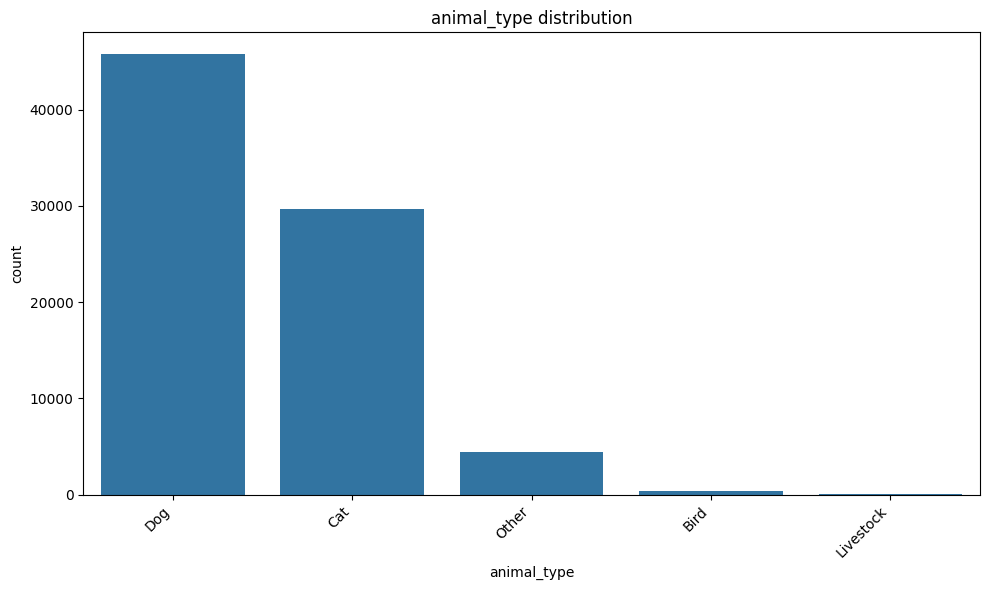

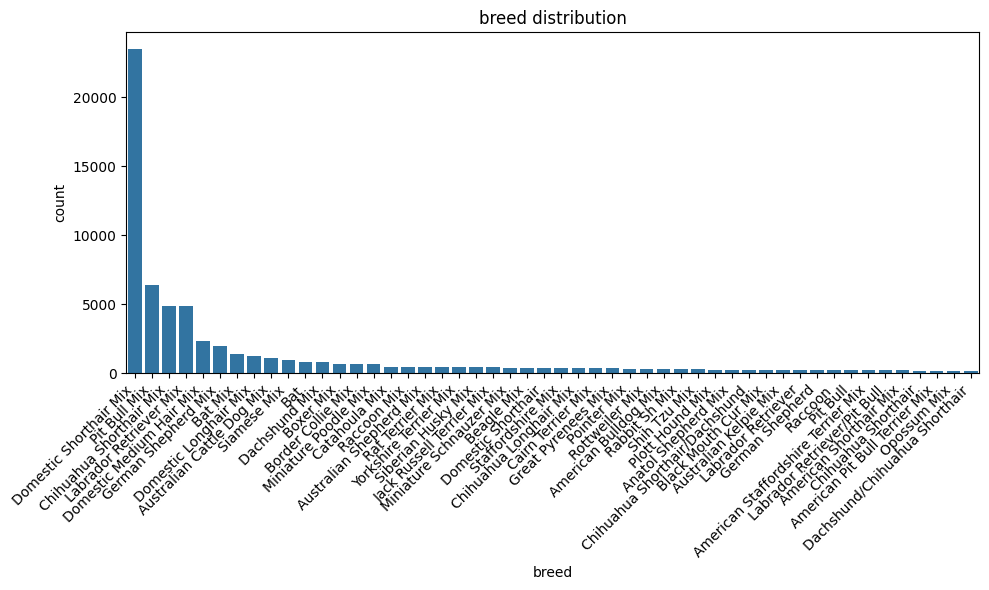

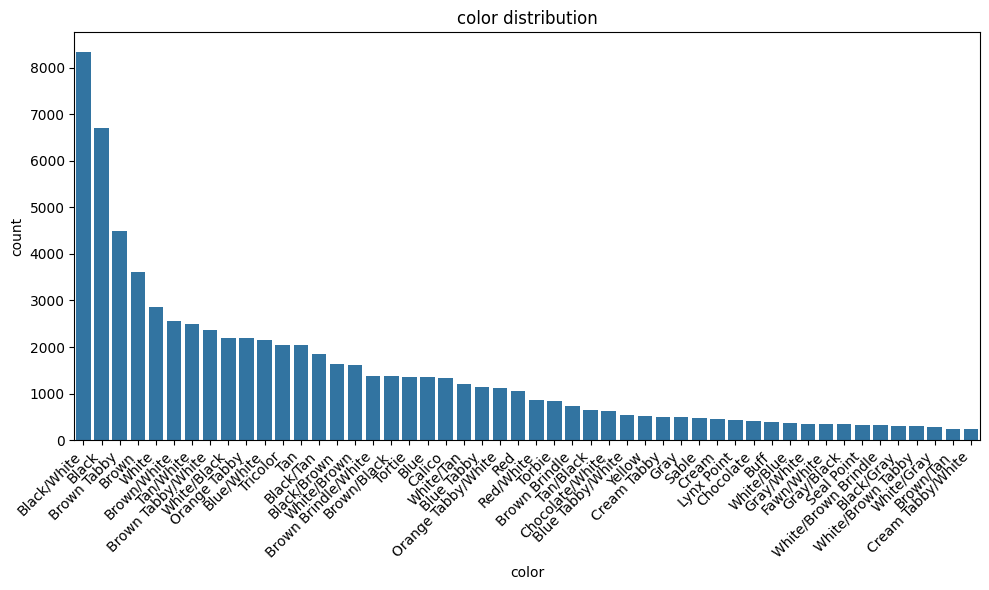

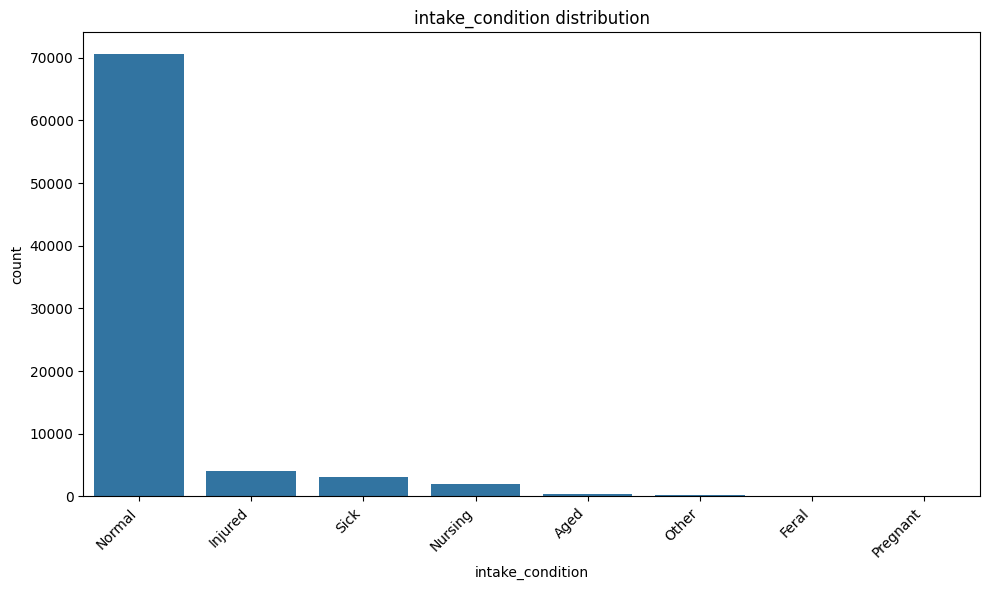

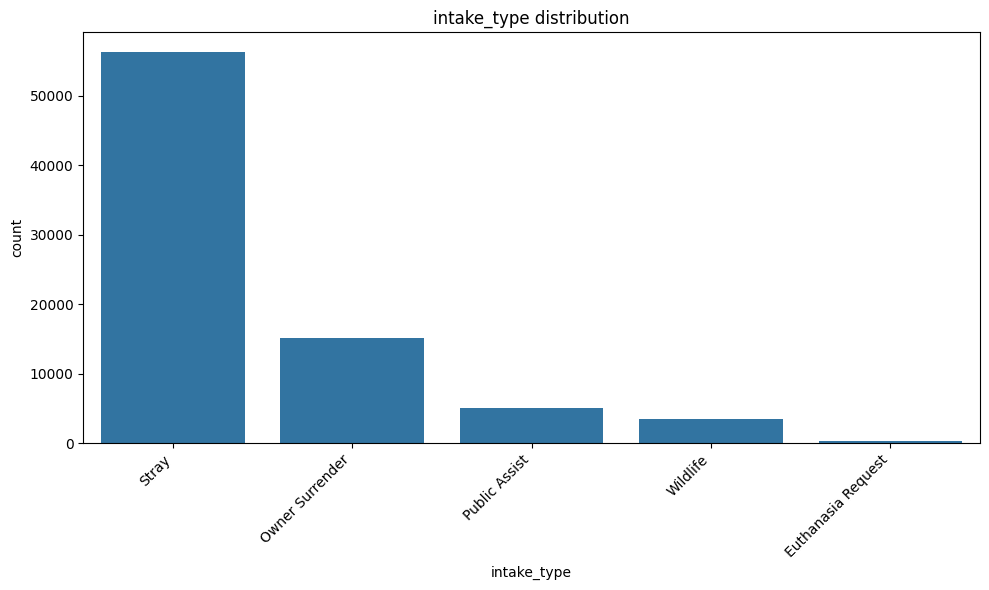

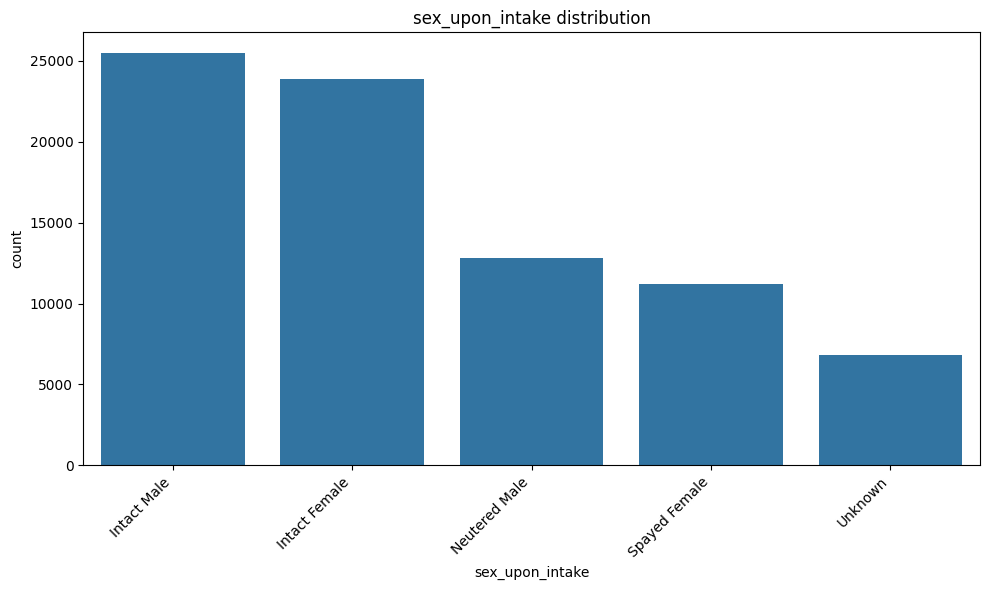

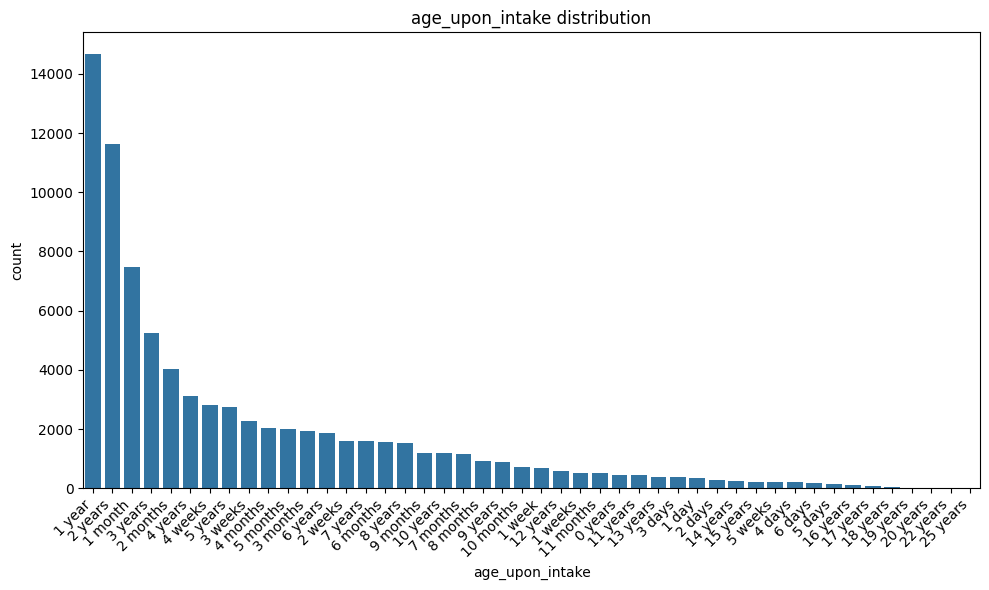

In [6]:
eda_cols = [
    'animal_type','breed', 'color',
    'intake_condition', 'intake_type',
    'sex_upon_intake', 'age_upon_intake'
]

for col in eda_cols:
    plt.figure(figsize = (10, 6))
    sns.countplot(data = df, x = col, order = df[col].value_counts().index[:50]) # Limit to 50 for clarity
    plt.title(col + " distribution")
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

**Initial observations**

*  `animal_type`: The data primarily included dogs and cats, with a much smaller number of species marked as `Other`, `Birds`, or '`Livestock`.

*  `breed`: Many mix-breed animals shown on this plot, a few purebred animals (e.g Labrador Retriever and Pitbull).
  * Some data appeared to be miscategorized here (e.g Bat and Raccoon).

*   `color`: Many unique values.

*  `intake_condition`: The majority of animals were categorized as `Normal` upon intake, with a much smaller amount marked as being `Injured`, `Sick`, `Nursing`, `Aged`, or `Pregnant`.

* `intake_type`: Contained mostly stray intakes, with smaller proportions of `Owner Surrender`, `Public Assists`, `Wildlife`, and `Euthanasia Request`.

*  `sex_upon_intake`: Overall, the distribution between sexes appear to be fairly equal. Mostly intact animals, less commonly fixed or unknown entries.

*  `age_upon_intake`: Displayed a long-tailed distribution with many unique values.


---



I was initally unsure if `Nursing` referred to baby animals that were nursing, or animal mothers that were nursing. Upon examination, it appears nursing applies to both conditions.

In [7]:
df[df['intake_condition'] == 'Nursing']

,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
27,2 weeks,A701811,Cat,Domestic Shorthair Mix,Gray Tabby,2015-05-05T07:29:00.000,2015-05-05T07:29:00.000,4434 Frontier Trl in Austin (TX),Nursing,Stray,NaN,Unknown
78,2 weeks,A724640,Cat,Domestic Shorthair Mix,Brown Tabby/Black,2016-04-20T08:19:00.000,2016-04-20T08:19:00.000,10636 Marshitahs in Austin (TX),Nursing,Stray,NaN,Intact Male
109,2 weeks,A728810,Cat,Domestic Shorthair Mix,Blue,2016-06-08T17:30:00.000,2016-06-08T17:30:00.000,8210 Chalk Knoll Drive in Austin (TX),Nursing,Stray,NaN,Intact Male
256,5 days,A746787,Cat,Domestic Shorthair Mix,White,2017-04-09T07:45:00.000,2017-04-09T07:45:00.000,1003 Mckie Dr in Austin (TX),Nursing,Stray,NaN,Intact Male
308,1 year,A700008,Cat,Domestic Shorthair Mix,Blue Tabby,2015-04-06T12:30:00.000,2015-04-06T12:30:00.000,2205 Voyageurs in Austin (TX),Nursing,Stray,NaN,Intact Female
...,...,...,...,...,...,...,...,...,...,...,...,...
79752,1 month,A749711,Cat,Domestic Shorthair Mix,Brown Tabby,2017-05-18T15:13:00.000,2017-05-18T15:13:00.000,10017 Pinnacle Crest Loop in Austin (TX),Nursing,Stray,Zeus,Intact Male
79982,3 days,A768755,Cat,Domestic Shorthair Mix,Brown Tabby,2018-03-24T15:50:00.000,2018-03-24T15:50:00.000,1406 Sahara Avenue in Austin (TX),Nursing,Stray,NaN,Unknown
79983,1 year,A768754,Cat,Domestic Shorthair Mix,Black,2018-03-24T15:50:00.000,2018-03-24T15:50:00.000,1406 Sahara Avenue in Austin (TX),Nursing,Stray,*Anya,Intact Female
80000,3 days,A768755,Cat,Domestic Shorthair Mix,Brown Tabby,2018-03-24T15:50:00.000,2018-03-24T15:50:00.000,1406 Sahara Avenue in Austin (TX),Nursing,Stray,NaN,Unknown


## 4. Selection of Features

After viewing the distribution plots of the features, I chose to focus on **6 features** for clustering that seemed most relevant:


*   `age_upon_intake`
* `animal_type`
* `breed`
* `intake_condition`
* `intake_type`
* `sex_upon_intake`

These were chosen because they *directly relate* to an animal's **physical traits** or **intake context**.

---


Note:
  * While I initially attempted to regroup `color`, this feature was ultimately excluded from my selection due to noise.


In [8]:
selected_features = [
    'age_upon_intake',
    'animal_type',
    'breed',
    'intake_condition',
    'intake_type',
    'sex_upon_intake'
    ]

df_processed = df[selected_features].copy()

In [9]:
# Quick review of df with selected features:
df_processed.head()

,age_upon_intake,animal_type,breed,intake_condition,intake_type,sex_upon_intake
0,8 years,Dog,English Springer Spaniel,Normal,Stray,Spayed Female
1,11 months,Dog,Basenji Mix,Normal,Stray,Intact Male
2,4 weeks,Cat,Domestic Shorthair Mix,Sick,Stray,Intact Female
3,4 years,Dog,Doberman Pinsch/Australian Cattle Dog,Normal,Stray,Neutered Male
4,2 years,Dog,Labrador Retriever Mix,Normal,Owner Surrender,Neutered Male


In [10]:
df_processed.isnull().sum()

,0
age_upon_intake,0
animal_type,0
breed,0
intake_condition,0
intake_type,0
sex_upon_intake,1


`df_processed.isnull().sum()` showed that `sex_upon_intake` has one missing value.


* This will be addressed in the next section.

## 5. Cleaning the Data and Feature Engineering

In this section, I regrouped excessively unique features into broader categories in order to make one-hot encoding less taxing. Regrouping, helped to reduce noise, especially for features like `breed` and `age_upon_intake` that were quite varied.


---




Based on EDA findings, the following **feature transformations** were made:

*  `animal_type`: Regrouped into `Dog`, `Cat`, and `Uncommon Animal` (to include lesser common species marked as bird, livestock, other).

*  `breed`:
  1. Handled misclassified data found during EDA (e.g bat, rabbit, raccoon) by grouping them as non-canine/feline species.
  2. Ultimately, regrouped into `Mixed breed`, `Pure breed`, and `Non-Canine/Feline Species` to make previously seen breed feature easier to interpret for clustering.

*  `intake_type`: Simplified into `Stray` and `Other` (which includes less frequent owner surrenders, public assists, wildlife, and euthanasia requests).

* `intake_condition`: Regrouped into `Healthy`(from normal), `Requiring Veterinary Care` (from injured/sick), `Maternal/Neonatal Care` (from nursing, pregnant), and `Other Special Needs`(from aged, feral) to better reflect animal health status upon intake.

*  `sex_upon_intake`: Due to fairly equal distribution between sexes, regrouped into `Fixed`, `Intact`, and `Unknown Fertile Status`(from unknown/no entry).

*  `age_upon_intake`: Converted into a numeric form `age_in_days` and then binned into `Young` or `Adult`




In [11]:
# Group animal types:
df_processed['animal_type'] = df_processed['animal_type'].apply(
    lambda x: 'Uncommon Animal' if x not in ['Dog', 'Cat'] else x
)

# Group intake types:
df_processed['intake_type'] = df_processed['intake_type'].apply(lambda x: x if x == 'Stray' else 'Uncommon Intake')

In [12]:
# Group breed types:
# Reclassify certain species mistakenly listed in breed category
misplaced_species = ['bat', 'rabbit', 'raccoon', 'chicken', 'skunk']
reclassified = 'Non-Canine/Feline Species'

# Group breed_binary as Pure bred vs. Mixed breeds vs. Non-Canine/Feline Species
df_processed['breed_binary'] = df_processed['breed'].apply(
    lambda x: (
        reclassified
        if any(species_name in str(x).lower() for species_name in misplaced_species)
        else ('Mixed breed' if 'mix' in str(x).lower() or '/' in str(x) else 'Pure breed')
    )
)

In [13]:
# Check that breed_binary is correct!
df_processed[['breed', 'breed_binary']].sample(20)

,breed,breed_binary
12445,English Bulldog Mix,Mixed breed
52908,Australian Cattle Dog Mix,Mixed breed
8365,Pit Bull Mix,Mixed breed
60061,Domestic Shorthair Mix,Mixed breed
54738,Domestic Shorthair Mix,Mixed breed
7689,Chihuahua Shorthair,Pure breed
8021,Domestic Shorthair Mix,Mixed breed
19221,Australian Shepherd Mix,Mixed breed
62680,Miniature Poodle Mix,Mixed breed
76257,Domestic Shorthair Mix,Mixed breed


In [14]:
# Group intake conditions:
def intake_condition_grouped(raw_condition):
  condition = str(raw_condition).lower().strip()

  if condition == 'normal':
    return 'Healthy'
  elif 'injured' in condition or 'sick' in condition:
    return 'Requiring Veterinary Care'
  elif 'nursing' in condition or 'pregnant' in condition:
    return 'Maternal/Neonatal Care'
  else:
    return 'Other Special Needs'

df_processed['intake_condition'] = df_processed['intake_condition'].apply(intake_condition_grouped)

In [15]:
def simplify_sex(x):
  if pd.isnull(x):          # for NaN value found
    return 'Unknown Fertile Status'

  x = str(x).lower()
  if 'spayed' in x or 'neutered' in x:
    return 'Fixed'
  elif 'intact' in x:
    return 'Intact'
  else:
    return 'Unknown Fertile Status'

df_processed['sex_grouped'] = df_processed['sex_upon_intake'].apply(simplify_sex)

### Convert and Bin Ages

In [16]:
# Convert age strings into age in total days:
def age_in_days(age_str):
    val, unit = str(age_str).split()
    val = int(val)

    if 'day' in unit:
        return val
    elif 'week' in unit:
        return val * 7
    elif 'month' in unit:
        return val * 30
    elif 'year' in unit:
        return val * 365

    return None  # Just in case unit isn't recognized

df_processed['age_in_days'] = df_processed['age_upon_intake'].apply(age_in_days)

In [17]:
# Bin ages:
age_cutoffs = [0, 364, df_processed['age_in_days'].max()]
age_labels = ['Young', 'Adult']

df_processed['age_groupings'] = pd.cut(
    df_processed['age_in_days'],
    bins = age_cutoffs,
    labels = age_labels,
    include_lowest = True     # Include 0-days-old animals in the young group
)

In [18]:
# Snippit of age transformation:
#  age_upon_intake = original text data
#  age_in_days = converted to total number of days
#  age_groupings = categorical group (Young/Adult)

df_processed[['age_upon_intake', 'age_in_days', 'age_groupings']].sample(20)

,age_upon_intake,age_in_days,age_groupings
11264,5 years,1825,Adult
37922,1 month,30,Young
49927,1 year,365,Adult
51615,4 weeks,28,Young
27640,2 years,730,Adult
61062,8 years,2920,Adult
48618,1 year,365,Adult
22586,2 years,730,Adult
30673,2 years,730,Adult
46047,3 years,1095,Adult


In [19]:
# Drop original and intermittent column 'age_in_days' after transforming
columns_to_drop = [
    'age_upon_intake',   # Replaced by age_in_days and age_groupings
    'age_in_days',       # Numeric replaced by bins
    'breed',             # Replaced by breed_binary
    'sex_upon_intake'    # Replaced by sex_grouped
]

df_processed = df_processed.drop(columns=columns_to_drop)

In [20]:
# Final set of cleaned features:
cluster_features = [
    'animal_type',
    'intake_condition',
    'intake_type',
    'breed_binary',
    'sex_grouped',
    'age_groupings'
]

## 6. Prepare for K-Means by One-Hot Encoding

I then prepared my features for K-Means clustering by one-hot encoding. One-hot encoding essentially converts the textual data (e.g `animal_type_Cat` or `animal_type_Dog`) into numerical data accepted by K-Means. This is done by creating binary columns for each type. Doing this ensures that distinct categories are treated equally and that K-Means doesn't rank them.

`df_for_clustering.head()` shows a snippit of how the data looks after one-hot encoding.

In [21]:
df_encoded = pd.get_dummies(df_processed[cluster_features], dtype = int)

In [22]:
df_for_clustering = df_encoded.copy()

In [23]:
df_for_clustering.head()

,animal_type_Cat,animal_type_Dog,animal_type_Uncommon Animal,intake_condition_Healthy,intake_condition_Maternal/Neonatal Care,intake_condition_Other Special Needs,intake_condition_Requiring Veterinary Care,intake_type_Stray,intake_type_Uncommon Intake,breed_binary_Mixed breed,breed_binary_Non-Canine/Feline Species,breed_binary_Pure breed,sex_grouped_Fixed,sex_grouped_Intact,sex_grouped_Unknown Fertile Status,age_groupings_Young,age_groupings_Adult
0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0
2,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1


### Correlation Check: Correlation Between One-Hot Encoded Features

This section lists pairs of one-hot encoded features that share a strong, positive correlation and indicates that one of the two features may be redundant.
* By creating a correlation matrix and then focusing on the upper triangle, I was then able to find feature pairs and their respective correlations without duplications.
* When considering one-hot encoded data, negative correlations close to -1 are expected and indicate that the pair is mutually exclusive from one another. So for the sake of checking for redundant features, I specifically filtered by  >= 0.7 to only show high, positive correlations.

In [24]:
corr = df_for_clustering.corr()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))  # Use upper triangle to avoid duplicates

pairs = upper_tri.stack().reset_index()
pairs.columns = ['feature_1', 'feature_2', 'Correlation']
high_corr = pairs[pairs['Correlation'] >= 0.7]

print(high_corr)

                      feature_1                               feature_2  \
38  animal_type_Uncommon Animal  breed_binary_Non-Canine/Feline Species   

    Correlation  
38     0.850711  


There is a high correlation between `animal_type_Uncommon Animal` and `breed_binary_Non-Canine/Feline Species`.

While this makes sense since `breed_binary_Non-Canine/Feline Species` were species types (bat, raccoon, etc.) misplaced in the original `breed`, it is also **redundant**. To help create meaningful clusters, I chose to drop `breed_binary_Non-Canine/Feline Species` and only keep `animal_type_Other`.

In [25]:
# Drop feature to avoid redundacy during clustering
df_for_clustering= df_for_clustering.drop(columns=['breed_binary_Non-Canine/Feline Species'])

## 7. Determining k Clusters

Before clustering can happen, the **number of clusters (k) must be determined**. To help me identify and evaluate the number of clusters to use, I used both *silhouette scores* and the *elbow method* with Within-Cluster Sum of Squares (WCSS).

### Silhouette Analysis

**Silhouette Coefficients** is a measure to evaluate how compact clusters are and how distinct they are compared to other clusters. Ideally, the closer the silhouette score is to 1, the better the clusters are and the closer to -1 indicates poor clusters.

k = 2 Silhouette Score: 0.308
k = 3 Silhouette Score: 0.337
k = 4 Silhouette Score: 0.366
k = 5 Silhouette Score: 0.418
k = 6 Silhouette Score: 0.453
k = 7 Silhouette Score: 0.507
k = 8 Silhouette Score: 0.536
k = 9 Silhouette Score: 0.567


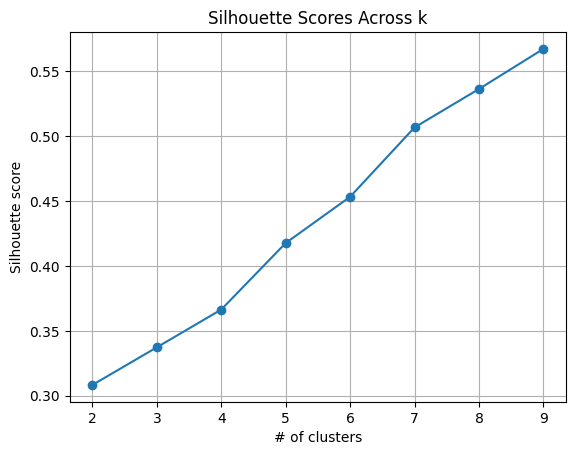

In [26]:
silhouette_scores = []

for k in range(2, 10):          # Can't have 1 cluster for silhouette
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10) # n_init = 10 for stability
    labels = km.fit_predict(df_for_clustering)
    score = silhouette_score(df_for_clustering, labels)
    silhouette_scores.append(score)
    print('k =', k, 'Silhouette Score:', round(score, 3))

plt.plot(range(2, 10), silhouette_scores, marker = 'o')
plt.title('Silhouette Scores Across k')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()

Considering that the silhouette score continued to steadily increase (from k = 2 through k = 9), **9  is likely the suggested optimal k**.






### Elbow Method

The **WCSS or Inertia** measures how compact the clusters are by calculating the sum of squared distances to the cluster center. WCSS are inversely related, so when k increases, inertia decreases. By finding the elbow, I was able to figure out where increasing the number of clusters no longer significantly improved cluster compactness.

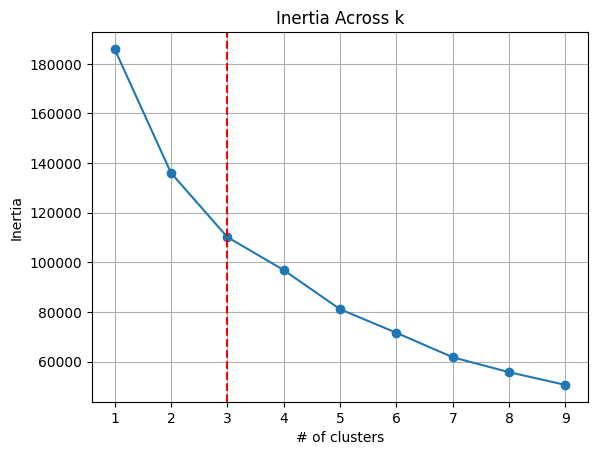

In [27]:
k_values= range(1, 10)
inertia_scores = []

for k in k_values:
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    km.fit(df_for_clustering)
    inertia_scores.append(km.inertia_)

kneedle = KneeLocator(k_values, inertia_scores, curve='convex', direction='decreasing')

plt.plot(k_values, inertia_scores, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.title('Inertia Across k')
plt.grid(True)

if kneedle.elbow is None:
    print('No elbow detected.', kneedle)
else:
    plt.axvline(kneedle.elbow, color = 'red', linestyle = '--')

plt.show()

The elbow method suggests that k = 3 is the optimal k.

## 8. Testing k = 3

In this section, I applied k = 3 (as suggested by the elbow method) and then evaluated the cluster quality by:

* **Cluster profiles heatmap**:
    Visualized *common animal features* in each cluster.
     * Filtered out rare features (present < 5% of all animals) for clarity.
* **Feature presence summary**:
    *Classifed features* into groups based on how prevalent they were:
     * Common = Features that were high (70%+) in *at least one* group
     * Uncommon = Features that were low (< 10%) across *all* groups
     * Borderline = Features that fell somewhere in between.



In [28]:
kmeans_k3 = KMeans(n_clusters = 3, random_state = 0, n_init = 10)
clusters_k3 = kmeans_k3.fit_predict(df_for_clustering)

df_clustered_k3 = df_for_clustering.copy()
df_clustered_k3['cluster'] = clusters_k3

### Cluster Heatmap and Presence Summary

In [29]:
def plot_cluster_heatmap(df, cluster_col = 'cluster', threshold = 0.05, cmap = 'YlGnBu'):
    ''' Heatmap of cluster profiles based on average feature presence.'''
    means  = df.groupby(cluster_col).mean()

    # Drop low average features to keep heatmap clean
    avg_presence = means.mean()
    low_freq  = avg_presence[avg_presence < threshold].index
    means  = means .drop(columns = low_freq)

    data = means.T
    data.index = [i.replace('_', ' ').title() for i in data.index]
    data = data.sort_index()

    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap = cmap, annot = True, fmt = '.2f')
    plt.title('Average Cluster Profile')
    plt.tight_layout()
    plt.show()

    return data

In [30]:
def summarize_feature_presence(df, high = 0.7, low = 0.1):
    common, uncommon, borderline = [], [], []

    for feature in df.index:
        vals = df.loc[feature]

        if (vals > high).any():
            common.append(feature)

        elif (vals < low).all():
            uncommon.append(feature)

        else:
            borderline.append(feature)

    print(len(common), 'Common features:', common)
    print(len(uncommon), 'Rare features:', uncommon)
    print(len(borderline), 'Borderline features:', borderline)

    return common, uncommon, borderline

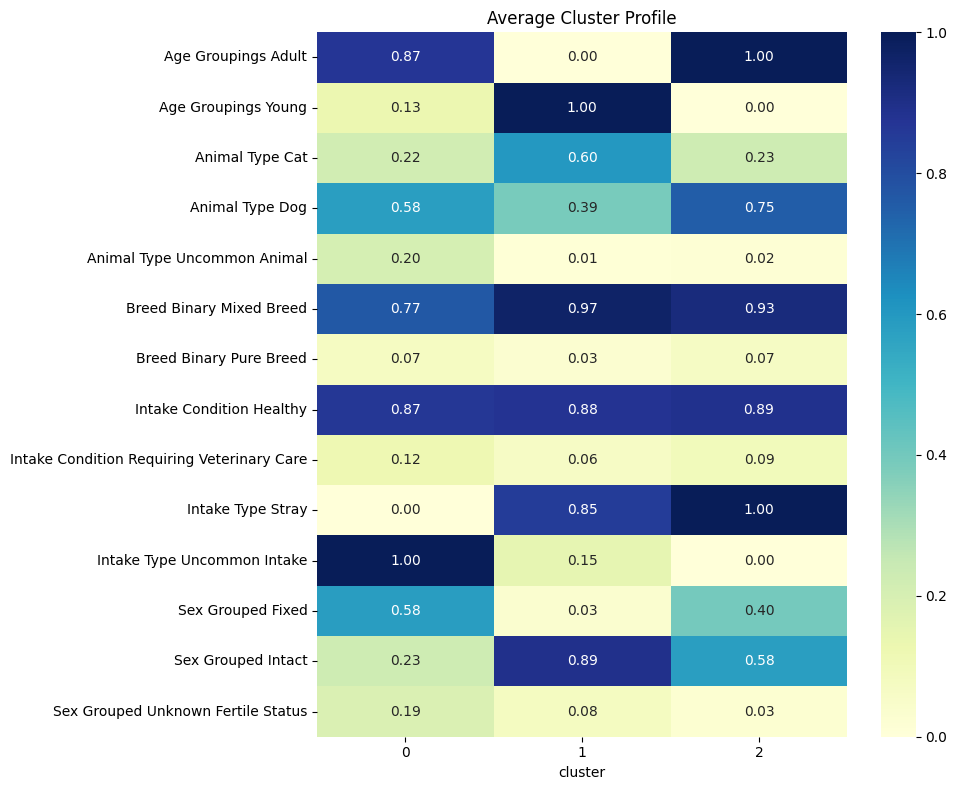

8 Common features: ['animal_type_Dog', 'intake_condition_Healthy', 'intake_type_Stray', 'intake_type_Uncommon Intake', 'breed_binary_Mixed breed', 'sex_grouped_Intact', 'age_groupings_Young', 'age_groupings_Adult']
3 Rare features: ['intake_condition_Maternal/Neonatal Care', 'intake_condition_Other Special Needs', 'breed_binary_Pure breed']
5 Borderline features: ['animal_type_Cat', 'animal_type_Uncommon Animal', 'intake_condition_Requiring Veterinary Care', 'sex_grouped_Fixed', 'sex_grouped_Unknown Fertile Status']


In [31]:
heatmap_data = plot_cluster_heatmap(df_clustered_k3)
means = df_clustered_k3.groupby('cluster').mean()
common, uncommon, borderline = summarize_feature_presence(means.T) # Transpose so features are rows for summary

Based on the heatmap, I drew the following **interpretations**:
 * Cluster 0: Adult dogs who are healthy and arrived via uncommon intake.
 * Cluster 1: Baby animals less than a 1 year old. Slightly more cats (0.60) than dogs (0.39). Usually healthy, intact, mixed-bred strays.
 * Cluster 2: Contained 100% of animals that entered the shelter in ways such as owner surrender, public assists, wildfire, or euthanasia request. Healthy, adult, mixed-bred dogs.

I also noticed that animal traits such as "mixed breed" and "healthy" were very frequent across all 3 clusters.

While this clustering provides a good general overview for traits like an animal's age or how they came into the system, there were still some animal traits that were being overlooked such as pure breds, those who require veterinary care, other special needs, or maternal/neonatal care.

The silhouette score of 0.337 at k = 3 supports my observation because these groups were ultimately not distinct enough.





## 9 Cluster Trial

I then repeated the process for k = 9 (suggested by the silhouette score plot) to see if more clusters would result in a more detailed picture of the animal groups.

In [32]:
# Repeat with k = 9 clusters
kmeans_k9 = KMeans(n_clusters = 9, random_state = 0, n_init = 10)
clusters_k9 = kmeans_k9.fit_predict(df_for_clustering)

df_clustered_k9 = df_for_clustering.copy()
df_clustered_k9['cluster'] = clusters_k9

### Cluster Heatmap and Presence Summary

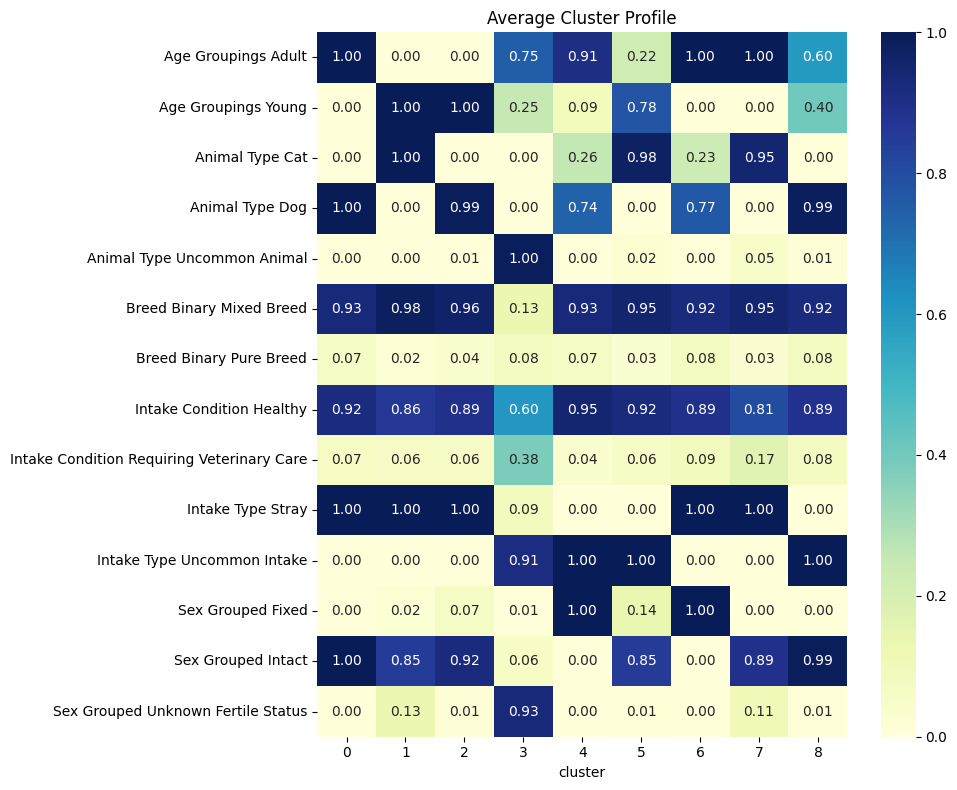

12 Common features: ['animal_type_Cat', 'animal_type_Dog', 'animal_type_Uncommon Animal', 'intake_condition_Healthy', 'intake_type_Stray', 'intake_type_Uncommon Intake', 'breed_binary_Mixed breed', 'sex_grouped_Fixed', 'sex_grouped_Intact', 'sex_grouped_Unknown Fertile Status', 'age_groupings_Young', 'age_groupings_Adult']
3 Rare features: ['intake_condition_Maternal/Neonatal Care', 'intake_condition_Other Special Needs', 'breed_binary_Pure breed']
1 Borderline features: ['intake_condition_Requiring Veterinary Care']


In [33]:
# Run the same cluster heatmap and summary for k = 9
means = df_clustered_k9.groupby('cluster').mean()
heatmap_data = plot_cluster_heatmap(df_clustered_k9)
common, uncommon, borderline = summarize_feature_presence(means.T)

### Top Z-scores

To better understand which features truly define each cluster, I found **the top 5 features**, based on *z-scores*, using the `get_top_features` function. The resulting top features for a given cluster are those who's average presence is significantly more common in that specific cluster compared to the overall average across all clusters.

For this section, I mainly wanted to focus on z-scores greater than 1.0+, which would suggest that the animal trait strongly contributed to defining their group. I then compared the driving features of each cluster to the cluster profiles heatmap to get a more comprehensive picture of the animal groups.

In [34]:
def get_top_features(df, cluster_col = 'cluster', top_n = 5):
    means = df.groupby(cluster_col).mean()
    stds = means.std().replace(0, np.nan) # Avoid division by zero for std = 0
    means_mean = means.mean()

    z = (means - means_mean) / stds

    top = {}
    for cluster in z.index:
        sorted_feats = z.loc[cluster].sort_values(ascending=False)
        top[cluster] = sorted_feats.head(top_n).round(2)

    print('Top', top_n, 'features per cluster:')
    for cluster, feats in top.items():
        print('\nCluster', cluster)
        print(feats.to_string())

    return top, z

In [35]:
top, z = get_top_features(df_clustered_k9)

Top 5 features per cluster:

Cluster 0
animal_type_Dog            1.04
age_groupings_Adult        0.92
intake_type_Stray          0.84
sex_grouped_Intact         0.84
breed_binary_Pure breed    0.61

Cluster 1
intake_condition_Maternal/Neonatal Care    2.22
age_groupings_Young                        1.42
animal_type_Cat                            1.35
intake_type_Stray                          0.84
sex_grouped_Intact                         0.51

Cluster 2
age_groupings_Young                        1.42
animal_type_Dog                            1.03
intake_condition_Maternal/Neonatal Care    0.93
intake_type_Stray                          0.84
sex_grouped_Intact                         0.67

Cluster 3
animal_type_Uncommon Animal                   2.66
sex_grouped_Unknown Fertile Status            2.63
intake_condition_Requiring Veterinary Care    2.51
breed_binary_Pure breed                       0.94
intake_type_Uncommon Intake                   0.93

Cluster 4
sex_grouped_Fixed     

**Cluster interpretations**:

* **Cluster 0**: Consists of intact, stray, adult dogs. Notably includes purebreds.
* **Cluster 1**: Consists of stray kittens, usually intact. Defined by higher needs for maternal/neonatal care.
* **Cluster 2**:  Intact puppies, higher likelihood of needing maternal/neonatal care. Usually stray.
* **Cluster 3**: Defined by uncommon animals with unknown reproductive status. Much higher likelihood of needing veterinary care. Usually arriving from uncommon means.
* **Cluster 4**: Fixed, adult dogs/cats arriving via uncommon intake. Usually healthy.
* **Cluster 5**: Kittens entering the system by uncommon means. Usually healthy and intact.
* **Cluster 6**: Fixed, adult, stray dogs/cats. Notably includes purebreds and animals needing special care.
* **Cluster 7**: Stray, adult cats, usually intact. Notably includes cats who are in need of veterinary care or are feral/aged.
* **Cluster 8**: Defined by intact, dogs arriving by uncommon intake means. Higher likelihood of being purebred.


---



## Final Recommendations

9 clusters provided a more complete and detailed understanding of animal groups.It also revealed "minority characteristics" that were previously overlooked, such as animals with medical conditions, pure breds, and exotic/uncommon animals. These details regarding an animal's health status and distinct traits better positions the shelter to meet their needs and find appropriate homes for them.

Considering these insights from k = 9 clusters, the following recommendations are set for the shelter staff:

1. Immediate intake procedures:
    * Majority of the animals (excluding those in fixed groups 4 & 6 and "unknown"s in group 3) are intact and will require neuter/spay procedures.
2. Specialized Medical Care:
    * Clusters 1 and 2: Both with higher populations of animals needing maternal/neonatal care. Targeted programs and care and could include:
         * Tailored feeding regimens
         * Foster programs specifically for nursing mothers and their babies
    * Cluster 3: This group is specifically comprised of uncommon animals whose healh histories are likely unknown. These animals should be flagged for imediate medical assessment from exotic specialists.
    * Clusters 6 and 7: These groups contain animals with "other special needs", specifically those who are feral/aged. Potential protocols could include behavioral training or even just the acceptance that these groups may take longer to acclimate.
3. Adoption campaigns:
    * Clusters 1 and 2: For those seeking to adopt a young puppy or kitten. These animals generally require routine medical care (most need to be fixed) but typically otherwise healthy.
    * Cluster 3: This group is composed of only uncommon/exotic animals. Adoption process should involve stricter requirements. Ideally, adopter will be someone with previous experience with the uncommon animal and understands their potential medical needs.
    * Clusters 4 and 6: For those who are seeking adult animals ready for immediate adoption. These animals are all fixed and typically healthy.


### Overall Shelter Intake Visual

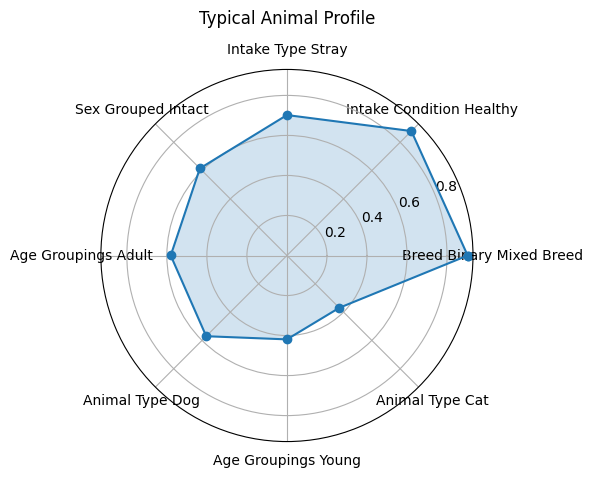

In [36]:
# Get overall average presence of each feature across all animals
avg_summary = df_clustered_k9.drop(columns = 'cluster').mean().sort_values(ascending = False)

# Limit to top N most common traits
top_n = 8
summary_top = avg_summary.head(top_n)

values = summary_top.values
labels = [label.replace('_', ' ').title() for label in summary_top.index]

angles = np.linspace(0, 2 * np.pi, len(values), endpoint = False)
values = np.append(values, values[0])
angles = np.append(angles, angles[0])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(polar = True))
ax.plot(angles, values, marker = 'o')
ax.fill(angles, values, alpha = 0.2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Typical Animal Profile', y = 1.1)
plt.tight_layout()
plt.show()

This radar plot visualizes the **average characteristics** across all animals at the shelter and represents what shelter staff will *likely see on their day-to-day*. These animals are:

* Primarily healthy, mixed bred animals.
* Usually intact, adult dogs, but also a significant number of kittens.

Overall, shelter staff might want to focus their resources on routine care since most animals are healthy. Consider strategies that focus on strays and intact protocols (e.g. spay/neuter outreach). When planning for space and services, account for the higher dog population but still ensure a good amount of those resources are still available to cats.



## Cluster "Nose Prints"

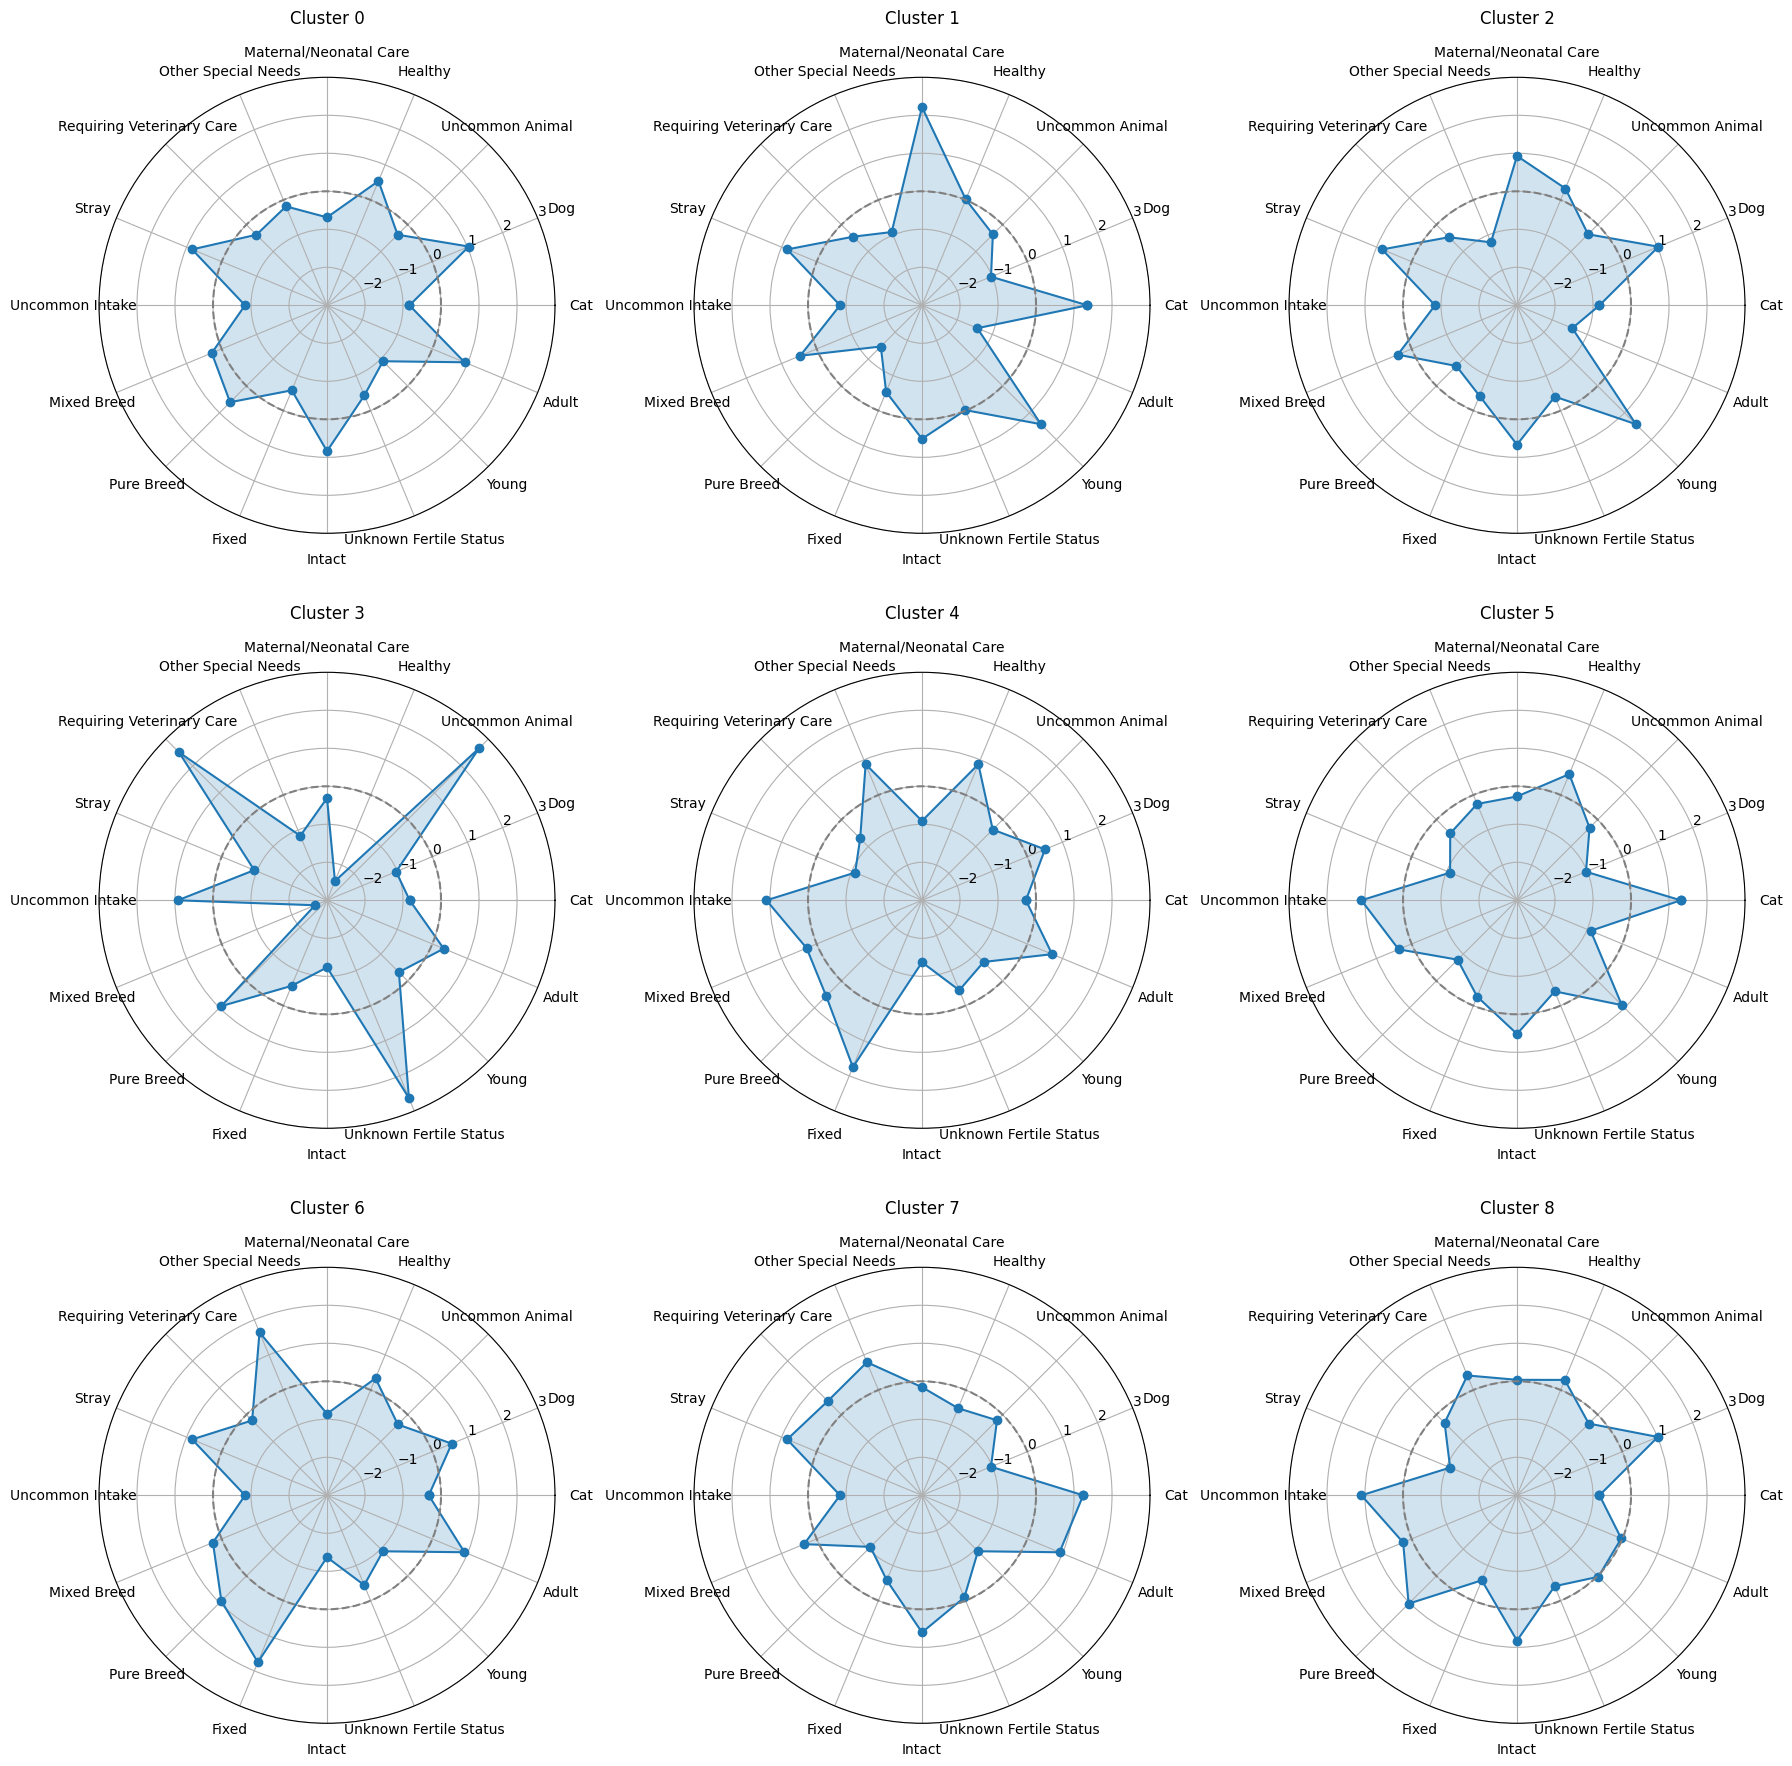

In [37]:
cols = 3
num_rows = math.ceil(len(z) / cols)

fig, axes = plt.subplots(num_rows, cols, figsize=(6 * cols, 6 * num_rows), subplot_kw = dict(polar = True))
axes = axes.flatten()

for i, cluster in enumerate(z.index):
    ax = axes[i]
    scores = z.loc[cluster]
    angles = np.linspace(0, 2 * np.pi, len(scores), endpoint = False)

    # Repeat first to close the radar loop
    scores = np.append(scores, scores.iloc[0])
    angles = np.append(angles, angles[0])

    ax.plot(angles, scores, marker = 'o')
    ax.fill(angles, scores, alpha = 0.2)

    labels = [col.split('_')[-1].title() for col in z.columns]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.tick_params(pad = 8)

    ax.set_ylim(-3, 3)
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title('Cluster ' + str(cluster), y = 1.1)

plt.tight_layout()
plt.show()

Each radar plot represents a cluster. Just like humans each have a unique fingerprint to identify them, the same can be said for an animal's nose print.

The plots are focused on the traits that make each animal group unique and sets them apart from the general population based on z-scores.

The dashed grey line is a baseline (0). Points closer to the center (negative numbers) indicate traits that are less common in that cluster than average. Points farther from the center (positive numbers) are traits that are more common in a specific cluster compared to the overall average and are therefor a highly defining characteristic for that group.

These visuals serve to provide a quick understanding of what makes each animal group unique. For example, Cluster 1's very obvious peak for maternal/neonatal care, Cluster 3's peak at uncommon animal and unknown fertile status, or Cluster 4 and 6's peaks at fixed.

## Limitations

* Clustering was completed on available features in the Austin Animal Shelter intake dataset. Additional detail such as specific medical diagnoses (beyond broad categories) and behavioral findings (e.g. aggressive, timid, friendly) could reveal even finer distinctions between groups.
* While k = 9 provided more detailed animal groups, it was ultimately a heuristic choice on my part by weighing both general and detailed outcomes. Different k values might produce different groupings.

# Future Work & Recommendations




These findings outline areas for future work:

* **Explore alternative clustering methods**:

    Try density-based algorithms, like DBSCAN to see how this affects how animals are grouped.

* **Incorporate behavioral data**:

    While it's implied that some groups may naturally be more fearful, agressive, etc., integrating behavioral findings could provide new and profound insights.

* Develop a **simple dashboard for shelter staff** to input an animal's basic intake information. This would allow the system to classify these new animals into one of the 9 groups and help staff to see the general path needed for that animal's adoption success.

* Predict likelihood of adoption:

    Use the established clusters to build a model that predicts the likelihood that an animal will be adopted. Flagging an animal with a "low chance of being adopted" early on can ultimately increase their chances of adoption.
    * Allows the staff and management to take a closer look via specialized assessments. For example, asking things like "is this cat truly feral and agressive, or just fearful and timid?"
    * Based on this assessment, the animal can then be marketed more favorably. (e.g. "A shy cat looking for a quiet, calm home" or "Restless dog who would thrive in a working, farm environment".).

Overall, this cluster set provides the Austin Animal Shelter with a solid foundation for continued research and development of future predictive models.